<a href="https://colab.research.google.com/github/venkat2ram/Python/blob/master/Chapter3_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the mnist data from sklearn data sets.

In [0]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784')

fetching the data from dataset.

In [2]:
X,y=mnist['data'],mnist['target']

print(X.shape,y.shape)

(70000, 784) (70000,)


Displaying a digit in plot.

In [0]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

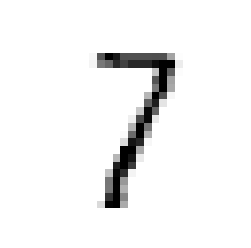

'2'

In [4]:
some_digit = X[36012]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()
y[36009]

Split the sets into traing and test sets.

In [0]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

In [0]:
import numpy as np
shuffle_index=np.random.permutation(60000)
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

First let's train for the data with digit 5.

In [0]:
y_train_5=(y_train=='5')
y_test_5=(y_test=='5')

Train the Stochastic gradient classifier.

In [8]:
from sklearn.linear_model import SGDClassifier 
SGDC=SGDClassifier(random_state=42)
SGDC.fit(X_train,y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [9]:
SGDC.predict([some_digit])

array([False])

Perform cross validation on the training dataset.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
  cln=clone(SGDC)
  X_fold_train=X_train[train_index]
  y_fold_train=y_train_5[train_index]
  X_fold_test=X_train[test_index]
  y_fold_test=y_train_5[test_index]
  cln.fit(X_fold_train,y_fold_train)
  y_pred=cln.predict(X_fold_test)
  n_pred=sum(y_pred==y_fold_test)
  print(n_pred/len(y_fold_test))
  
  
  

0.96235
0.96735
0.9649


Now perform cross validation using cross_val_score() function.


In [0]:
from sklearn.model_selection import cross_val_score
cvs=cross_val_score(SGDC,X_train,y_train_5,cv=3,scoring='accuracy')

In [12]:
cvs

array([0.96235, 0.96735, 0.9649 ])

We can not depend on The accuracies. If our model predicts eevery thing ngative we will get accuracy as 90%. This is because only 10% of all the records in dataset are of digit 5.

So we need a better way to check if the predictions are actually acurate. For this compare predict set with target data in data set using confusion matrix.

In [0]:
y_t=SGDC.predict(X_train)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_t, y_train_5)

array([[54136,  1163],
       [  443,  4258]])